In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import scikit_posthocs as sp
from scipy import stats
from scipy.stats import f_oneway, shapiro, levene
from scipy.stats import kruskal
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [2]:
import warnings
warnings.filterwarnings("ignore", message="scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate.")

### Read and structure data sets

In [4]:
crime_df = pd.read_csv('Crime_Reports_1.csv', low_memory=False)
response_df = pd.read_csv('APD_Average_Response_Time_by_Day_and_Hour.csv', low_memory=False)
dispatch_df = pd.read_csv('APD_Computer_Aided_Dispatch_Incidents.csv', low_memory=False)

In [5]:
response_df.head()

,Incident Number,Council District,Incident Type,Mental Health Flag,Priority Level,Response Datetime,Response Day of Week,Response Hour,First Unit Arrived Datetime,Call Closed Datetime,...,Number of Units Arrived,Unit Time on Scene,Call Disposition Description,Report Written Flag,Response Time,Officer Injured/Killed Count,Subject Injured/Killed Count,Other Injured/Killed Count,Geo ID,Census Block Group
0,210390914,3,Dispatched Incident,Mental Health Incident,Priority 3,02/08/2021 03:39:41 PM,Mon,15,02/08/2021 03:49:23 PM,02/08/2021 05:27:33 PM,...,2.0,7948.0,No Report,False,646.0,0,0,0,4.845300e+11,4.530020e+09
1,213190528,6,Dispatched Incident,Not Mental Health Incident,Priority 2,11/15/2021 10:35:44 AM,Mon,10,11/15/2021 11:27:08 AM,11/15/2021 11:34:16 AM,...,1.0,428.0,No Report,False,3109.0,0,0,0,4.849102e+11,4.910203e+09
2,190361790,4,Dispatched Incident,Not Mental Health Incident,Priority 2,02/05/2019 09:27:53 PM,Tue,21,02/05/2019 09:45:54 PM,02/05/2019 09:47:47 PM,...,1.0,113.0,No Report,False,1091.0,0,0,0,4.845304e+11,4.530400e+09
3,140571346,Other,Dispatched Incident,Not Mental Health Incident,Priority 0,02/26/2014 08:29:31 PM,Wed,20,02/26/2014 08:34:20 PM,02/26/2014 08:56:35 PM,...,3.0,2718.0,Unable To Locate,False,349.0,0,0,0,4.845303e+11,4.530317e+09
4,141450671,Other,Dispatched Incident,Not Mental Health Incident,Priority 3,05/25/2014 09:25:29 AM,Sun,9,05/25/2014 09:33:32 AM,05/25/2014 09:37:42 AM,...,1.0,250.0,No Report,False,489.0,0,0,0,4.845304e+11,4.530434e+09


In [6]:
crime_df.head()

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Council District,APD Sector,APD District,Clearance Status,Clearance Date,UCR Category,Category Description,Census Block Group
0,20145009834,THEFT BY SHOPLIFTING,607,N,03/04/2014 18:15,03/04/2014,1815.0,03/04/2014 18:34,03/04/2014,1834.0,COMMERCIAL / OFFICE BUILDING,7.0,AD,1,N,03/05/2014,23C,Theft,4.530324e+09
1,20205009412,FORGERY BY MAKING,1003,N,01/15/2020 17:14,01/15/2020,1714.0,03/05/2020 17:14,03/05/2020,1714.0,COMMERCIAL / OFFICE BUILDING,9.0,GE,3,C,05/05/2020,NaN,NaN,4.530011e+09
2,20093201450,ROBBERY BY ASSAULT,303,N,11/16/2009 18:24,11/16/2009,1824.0,11/16/2009 18:24,11/16/2009,1824.0,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,4.0,ID,2,N,12/04/2009,120,Robbery,4.530402e+09
3,20101641369,POSS OF FIREARM BY FELON,1502,N,06/13/2010 15:31,06/13/2010,1531.0,06/13/2010 15:31,06/13/2010,1531.0,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,3.0,HE,3,C,06/14/2010,NaN,NaN,4.530023e+09
4,2011201917,FAILURE TO IDENTIFY,2707,N,01/20/2011 22:31,01/20/2011,2231.0,01/20/2011 23:03,01/20/2011,2303.0,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,4.0,ID,5,C,02/15/2011,NaN,NaN,4.530021e+09


In [7]:
dispatch_df.head()

,Incident Number,Incident Type,Council District,Mental Health Flag,Priority Level,Response Datetime,Response Year,Response Month,Response Day of Week,Response Hour,...,Number of Units Arrived,Unit Time on Scene,Call Disposition Description,Report Written Flag,Response Time,Officer Injured/Killed Count,Subject Injured/Killed Count,Other Injured/Killed Count,Geo ID,Census Block Group
0,140151589,Officer-Initiated Incident,0,Not Mental Health Incident,Priority 3,01/15/2014 07:50:38 PM,2014,Jan,Wed,19,...,1.0,10791.0,Report Written,Yes,NaN,0,0,0,4.845304e+11,4.530400e+09
1,230351076,Dispatched Incident,9,Not Mental Health Incident,Priority 3,02/04/2023 04:32:26 PM,2023,Feb,Sat,16,...,1.0,473.0,No Report,No,5597.0,0,0,0,4.845300e+11,4.530011e+09
2,222891409,Officer-Initiated Incident,8,Not Mental Health Incident,Priority 3,10/16/2022 08:10:12 PM,2022,Oct,Sun,20,...,1.0,439.0,Report Written,Yes,NaN,0,0,0,4.845300e+11,4.530019e+09
3,223051197,Dispatched Incident,9,Mental Health Incident,Priority 2,11/01/2022 07:43:30 PM,2022,Nov,Tue,19,...,3.0,21668.0,Report Written MH,No,5212.0,0,0,0,4.845300e+11,4.530013e+09
4,223290364,Dispatched Incident,9,Not Mental Health Incident,Priority 2,11/25/2022 08:06:54 AM,2022,Nov,Fri,8,...,1.0,1195.0,False Alarm,No,829.0,0,0,0,4.845300e+11,4.530013e+09


In [8]:
# merge crime_df and response_df on 'Incident Number'
merged_df_1 = pd.merge(crime_df, response_df, on='Incident Number', how='inner')

In [ ]:
# merge the resulting dataframe with dispatch_df on 'Incident Number'
merged_df = pd.merge(merged_df_1, dispatch_df, on='Incident Number', how='inner')

In [ ]:
merged_df.head()

In [ ]:
merged_df.info()

In [266]:
merged_df.head(15)

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,...,Final Problem Category_y,Number of Units Arrived_y,Unit Time on Scene_y,Call Disposition Description_y,Report Written Flag_y,Response Time_y,Officer Injured/Killed Count_y,Subject Injured/Killed Count_y,Other Injured/Killed Count_y,Geo ID_y
0,201611224,AGG ASLT STRANGLE/SUFFOCATE,410,Y,01/01/2016 06:00,01/01/2016,600.0,01/01/2016 06:47,01/01/2016,647.0,...,Disturbance,1.0,4228.0,Report Written,Yes,709.0,0,0,0,4.845304e+11
1,202331367,FAMILY DISTURBANCE,3400,N,01/03/2023 23:09,01/03/2023,2309.0,01/03/2023 23:09,01/03/2023,2309.0,...,Welfare Check,3.0,3802.0,Report Written MH,No,934.0,0,0,0,4.845300e+11
2,200871472,VIOL CITY ORDINANCE - OTHER,3299,N,01/07/2008 17:27,01/07/2008,1727.0,01/07/2008 17:27,01/07/2008,1727.0,...,Shoot/Stab,4.0,2410.0,Unable To Locate,No,189.0,0,0,0,4.845300e+11
3,200591232,CUSTODY ARREST TRAFFIC WARR,3722,N,01/09/2005 16:52,01/09/2005,1652.0,01/09/2005 18:18,01/09/2005,1818.0,...,Burglary,1.0,2699.0,Report Written,Yes,1515.0,0,0,0,4.845300e+11
4,201450816,FAMILY DISTURBANCE,3400,N,01/05/2014 13:43,01/05/2014,1343.0,01/05/2014 14:43,01/05/2014,1443.0,...,Disorderly Conduct,1.0,1089.0,No Report,No,NaN,0,0,0,4.845300e+11
5,200741530,CRIMINAL MISCHIEF,1400,N,01/04/2007 18:23,01/04/2007,1823.0,01/04/2007 18:23,01/04/2007,1823.0,...,Other,1.0,890.0,Non-Police Matter,No,NaN,0,0,0,4.845300e+11
6,201570580,BURGLARY NON RESIDENCE,502,N,01/06/2015 19:00,01/06/2015,1900.0,01/07/2015 10:03,01/07/2015,1003.0,...,Disturbance,2.0,6246.0,No Report MH,No,10965.0,0,0,0,4.845300e+11
7,202390345,CRIMINAL TRESPASS,2716,N,01/09/2023 09:01,01/09/2023,901.0,01/09/2023 09:01,01/09/2023,901.0,...,Welfare Check,2.0,5476.0,No Report,No,633.0,0,0,0,4.845303e+11
8,202061139,BURGLARY NON RESIDENCE,502,N,12/24/2018 12:00,12/24/2018,1200.0,01/06/2020 16:07,01/06/2020,1607.0,...,Simple Assault,2.0,14983.0,Report Written,Yes,624.0,0,0,0,4.845304e+11
9,201851470,DWI,2100,N,01/05/2018 19:35,01/05/2018,1935.0,01/05/2018 19:35,01/05/2018,1935.0,...,Disturbance,2.0,625.0,No Report,No,874.0,0,0,0,4.845300e+11


### Data Cleaning

In [ ]:
merged_df = merged_df.drop(columns=['Census Block Group', 'Council District'])

In [ ]:
# keep columns without '_y'
columns_to_keep = [col for col in merged_df.columns if not col.endswith('_y')]

# create a new DataFrame with the selected columns
cleaned_df = merged_df[columns_to_keep].copy()

# rename '_x' columns to remove the '_x'
cleaned_df.columns = [col[:-2] if col.endswith('_x') else col for col in cleaned_df.columns]

print(cleaned_df.columns)

In [ ]:
cleaned_df.head(20)

In [264]:
# calculate the percentage of null values in each column
null_percentage = (cleaned_df.isnull().sum() / len(merged_df)) * 100

# sort 
null_percentage = null_percentage.sort_values(ascending=False)

print(null_percentage)

Category Description            74.173060
UCR Category                    74.173060
Response Time                   23.484579
Clearance Status                23.235608
Clearance Date                  17.326355
Census Block Group               2.565927
Council District                 1.615772
Geo ID                           1.031452
Location Type                    0.736751
APD District                     0.121945
APD Sector                       0.091459
Occurred Time                    0.005081
Occurred Date Time               0.005081
Final Problem Category           0.000000
Number of Units Arrived          0.000000
Call Disposition Description     0.000000
Unit Time on Scene               0.000000
Final Problem Description        0.000000
Initial Problem Category         0.000000
Incident Number                  0.000000
Report Written Flag              0.000000
Sector                           0.000000
Officer Injured/Killed Count     0.000000
Subject Injured/Killed Count     0

In [268]:
# drop rows where response time is missing, also drop unnecessary columns
merged_df_clean = cleaned_df.dropna(subset=['Response Time']).copy().drop(columns=['Response Year', 'Response Month', 'Clearance Status', 'Clearance Date',
                                                                                  'Report Written Flag', 'Final Problem Description',
                                                                                  'Final Problem Category', 'Call Disposition Description', 'Initial Problem Description',
                                                                                  'Initial Problem Category', 'Call Closed Datetime', 'Other Injured/Killed Count',
                                                                                  'Officer Injured/Killed Count', 'Subject Injured/Killed Count'])

merged_df_clean["Occurred Date Time"] = pd.to_datetime(merged_df_clean["Occurred Date Time"])
merged_df_clean = merged_df_clean[~merged_df_clean["Occurred Date Time"].dt.year.isin([2003, 2025])]
merged_df_clean.head()

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,...,Priority Level,Response Datetime,Response Day of Week,Response Hour,First Unit Arrived Datetime,Sector,Number of Units Arrived,Unit Time on Scene,Response Time,Geo ID
0,201611224,AGG ASLT STRANGLE/SUFFOCATE,410,Y,2016-01-01 06:00:00,01/01/2016,600.0,01/01/2016 06:47,01/01/2016,647.0,...,Priority 2,06/09/2020 07:23:53 PM,Tue,19,06/09/2020 07:34:36 PM,Edward,1.0,4228.0,709.0,4.845304e+11
1,202331367,FAMILY DISTURBANCE,3400,N,2023-01-03 23:09:00,01/03/2023,2309.0,01/03/2023 23:09,01/03/2023,2309.0,...,Priority 3,08/20/2020 09:17:07 PM,Thu,21,08/20/2020 09:30:22 PM,David,3.0,3802.0,934.0,4.845300e+11
2,200871472,VIOL CITY ORDINANCE - OTHER,3299,N,2008-01-07 17:27:00,01/07/2008,1727.0,01/07/2008 17:27,01/07/2008,1727.0,...,Priority 1,03/27/2020 11:09:03 PM,Fri,23,03/27/2020 11:11:51 PM,Frank,4.0,2410.0,189.0,4.845300e+11
3,200591232,CUSTODY ARREST TRAFFIC WARR,3722,N,2005-01-09 16:52:00,01/09/2005,1652.0,01/09/2005 18:18,01/09/2005,1818.0,...,Priority 3,02/28/2020 02:41:57 PM,Fri,14,02/28/2020 03:04:14 PM,Frank,1.0,2699.0,1515.0,4.845300e+11
6,201570580,BURGLARY NON RESIDENCE,502,N,2015-01-06 19:00:00,01/06/2015,1900.0,01/07/2015 10:03,01/07/2015,1003.0,...,Priority 2,06/05/2020 11:03:46 AM,Fri,11,06/05/2020 02:03:23 PM,Baker,2.0,6246.0,10965.0,4.845300e+11


In [262]:
print(merged_df_clean.columns)

Index(['Incident Number', 'Highest Offense Description',
       'Highest Offense Code', 'Family Violence', 'Occurred Date Time',
       'Occurred Date', 'Occurred Time', 'Report Date Time', 'Report Date',
       'Report Time', 'Location Type', 'Council District', 'APD Sector',
       'APD District', 'UCR Category', 'Category Description',
       'Census Block Group', 'Incident Type', 'Mental Health Flag',
       'Priority Level', 'Response Datetime', 'Response Day of Week',
       'Response Hour', 'First Unit Arrived Datetime', 'Sector',
       'Number of Units Arrived', 'Unit Time on Scene', 'Response Time',
       'Geo ID', 'Year', 'Day of Week'],
      dtype='object')


### Exploratory Data Analysis

In [274]:
merged_df_clean['Response Time'].describe()

count    14780.000000
mean      1429.287957
std       2835.410496
min          6.000000
25%        351.750000
50%        594.000000
75%       1198.000000
max      60689.000000
Name: Response Time, dtype: float64

In [ ]:
# filter for the row with the max and min to evaluate
outlier_row = merged_df_clean[merged_df_clean['Response Time'] == 60689]

# outlier_row
print(outlier_row[['Sector', 'Priority Level', 'Response Time']])

In [ ]:
outlier_row2 = merged_df_clean[merged_df_clean['Response Time'] == 6]
outlier_row2

In [ ]:
# test how removing outlier affects avg response time
sector_name = 'Edward' 

# avg before removing the outlier
avg_response_time_before = merged_df_clean[merged_df_clean['Sector'] == sector_name]['Response Time'].mean()
print(f"Average Response Time for {sector_name} before removing outlier: {avg_response_time_before}")

In [ ]:
merged_df_no_outlier = merged_df_clean[merged_df_clean['Response Time'] != 60689]

# avg response time after removing the outlier
avg_response_time_after = merged_df_no_outlier[merged_df_no_outlier['Sector'] == sector_name]['Response Time'].mean()
print(f"Average Response Time for {sector_name} after removing outlier: {avg_response_time_after}")

Change in the average response time in Edward does not appear to be significantly impacted by the max response time indicating it is not an error skewing the data, there are other data points within this range.

In [ ]:
merged_df_clean['Priority Level'].describe()

In [ ]:
# clean priority levels to make it numeric
pd.set_option('future.no_silent_downcasting', True)
merged_df_clean.loc[:, 'Priority Level'] = merged_df_clean['Priority Level'].replace({
    'Priority 0': 0,
    'Priority 1': 1,
    'Priority 2': 2,
    'Priority 3': 3,
    'Priority 4': 4
}).astype(int)

In [ ]:
merged_df_clean['Priority Level'].describe()

In [ ]:
# boxplot distribution of response time by priority level
plt.figure(figsize=(10, 6))
sns.boxplot(x='Priority Level', y='Response Time', data=merged_df_clean)
plt.title('Response Time by Priority Level')
plt.xlabel('Priority Level')
plt.ylabel('Response Time (seconds)')
plt.show()

#### Test for significant differences in response times between priority levels

In [ ]:
# check normality assumption for each priority level
for level in merged_df_clean['Priority Level'].unique():
    data = merged_df_clean.loc[merged_df_clean['Priority Level'] == level, 'Response Time']
    stat, p = shapiro(data)
    print(f"Priority {level}: Shapiro-Wilk test p-value = {p:.4f}")

# check homogeneity of variance
stat, p = levene(
    *[merged_df_clean.loc[merged_df_clean['Priority Level'] == level, 'Response Time']
      for level in merged_df_clean['Priority Level'].unique()]
)
print(f"Levene's test p-value = {p:.4f}")

p-values are all 0, indicating assumptions are violated for normality and homogeneity of variance. A non-parametric test will need to be done.

In [34]:
# perform Kruskal-Wallis test
kruskal_result = kruskal(
    *[merged_df_clean.loc[merged_df_clean['Priority Level'] == level, 'Response Time']
      for level in merged_df_clean['Priority Level'].unique()]
)

print(f"Kruskal-Wallis p-value = {kruskal_result.pvalue:.4f}")

Kruskal-Wallis p-value = 0.0000


In [35]:
# Dunn's test
dunn_result = sp.posthoc_dunn(merged_df_clean, val_col='Response Time', group_col='Priority Level')

print(dunn_result)

               0              1              2              3
0   1.000000e+00   1.922782e-15  1.675209e-174   0.000000e+00
1   1.922782e-15   1.000000e+00  5.049597e-118   0.000000e+00
2  1.675209e-174  5.049597e-118   1.000000e+00  7.503423e-243
3   0.000000e+00   0.000000e+00  7.503423e-243   1.000000e+00


All response times have highly significant differences between each other.

In [37]:
# group by priority level and get the mean response time
priority_means = merged_df_clean.groupby('Priority Level')['Response Time'].mean()
print(priority_means)

Priority Level
0     427.942117
1     540.269308
2    1171.389359
3    3597.243970
Name: Response Time, dtype: float64


### Test for correlations between variables

In [39]:
# Pearson correlation
correlation = merged_df_clean['Priority Level'].corr(merged_df_clean['Response Time'])
print(f"Correlation between Priority Level and Response Time: {correlation}")

Correlation between Priority Level and Response Time: 0.33009647457773933


In [40]:
# Spearman's correlation
correlation = merged_df_clean['Priority Level'].corr(merged_df_clean['Response Time'], method='spearman')
print(f"Spearman's correlation between Priority Level and Response Time: {correlation}")

Spearman's correlation between Priority Level and Response Time: 0.46687530549258366


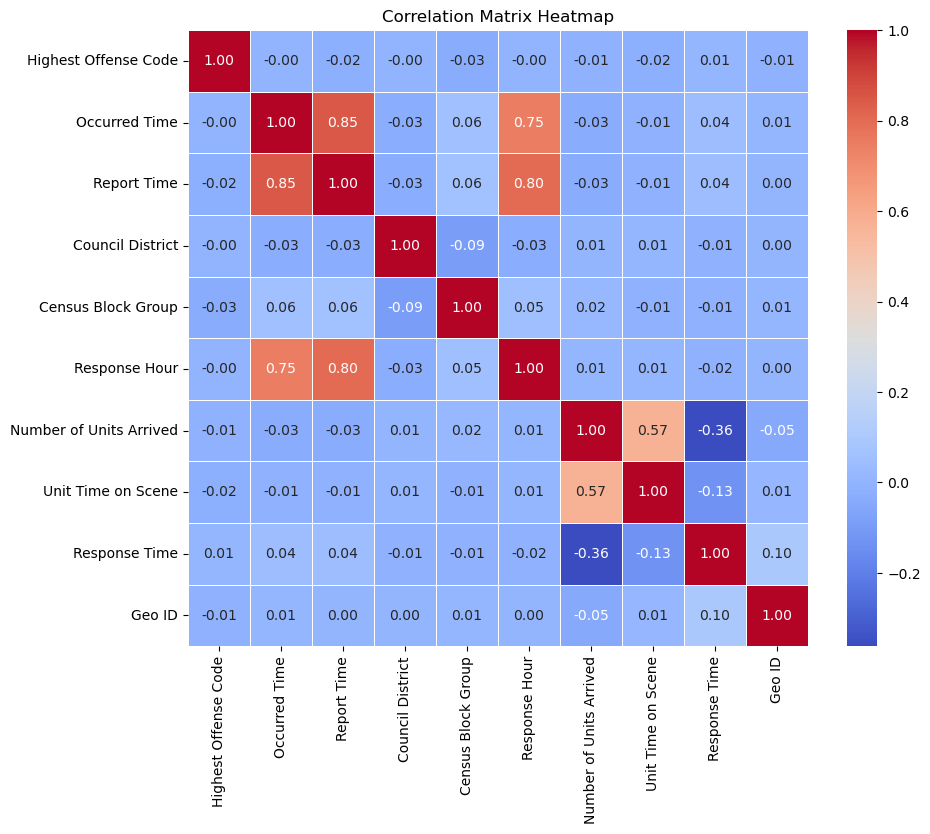

In [41]:
# select only numeric columns
numeric_df = merged_df_clean.select_dtypes(include=['number'])
numeric_df = numeric_df.drop(columns=['Incident Number'], errors='ignore')

# calculate correlation matrix
correlation_matrix = numeric_df.corr(method='spearman')

plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

In [42]:
# convert values to numeric
merged_df_clean.loc[:, 'Priority Level'] = pd.to_numeric(merged_df_clean['Priority Level'], errors='coerce')

merged_df_clean.loc[:, 'Response Time'] = pd.to_numeric(merged_df_clean['Response Time'], errors='coerce')

print(merged_df_clean[['Priority Level', 'Response Time']].dtypes)

Priority Level     object
Response Time     float64
dtype: object


In [43]:
merged_df_clean['Priority Level'] = pd.to_numeric(merged_df_clean['Priority Level'], errors='coerce')

In [44]:
print(merged_df_clean['Priority Level'].dtype)

int64


In [45]:
print(correlation_matrix)

                         Highest Offense Code  Occurred Time  Report Time  \
Highest Offense Code                 1.000000      -0.004025    -0.016953   
Occurred Time                       -0.004025       1.000000     0.850662   
Report Time                         -0.016953       0.850662     1.000000   
Council District                    -0.003908      -0.030914    -0.029152   
Census Block Group                  -0.033226       0.057097     0.059176   
Response Hour                       -0.004176       0.747825     0.802387   
Number of Units Arrived             -0.011838      -0.032717    -0.032840   
Unit Time on Scene                  -0.018777      -0.010497    -0.006036   
Response Time                        0.009688       0.038311     0.038641   
Geo ID                              -0.009281       0.007212     0.004848   

                         Council District  Census Block Group  Response Hour  \
Highest Offense Code            -0.003908           -0.033226      -0.00

### Evaluating differences between districts

In [47]:
# count of crimes by sector
crime_by_sector = merged_df_clean.groupby('Sector')['Incident Number'].count()

In [48]:
crime_by_sector

Sector
Adam       1638
Airport     120
Baker      1585
Charlie    1653
David      1989
Edward     2299
Frank      1819
George      678
Henry      1396
Ida        1603
Name: Incident Number, dtype: int64

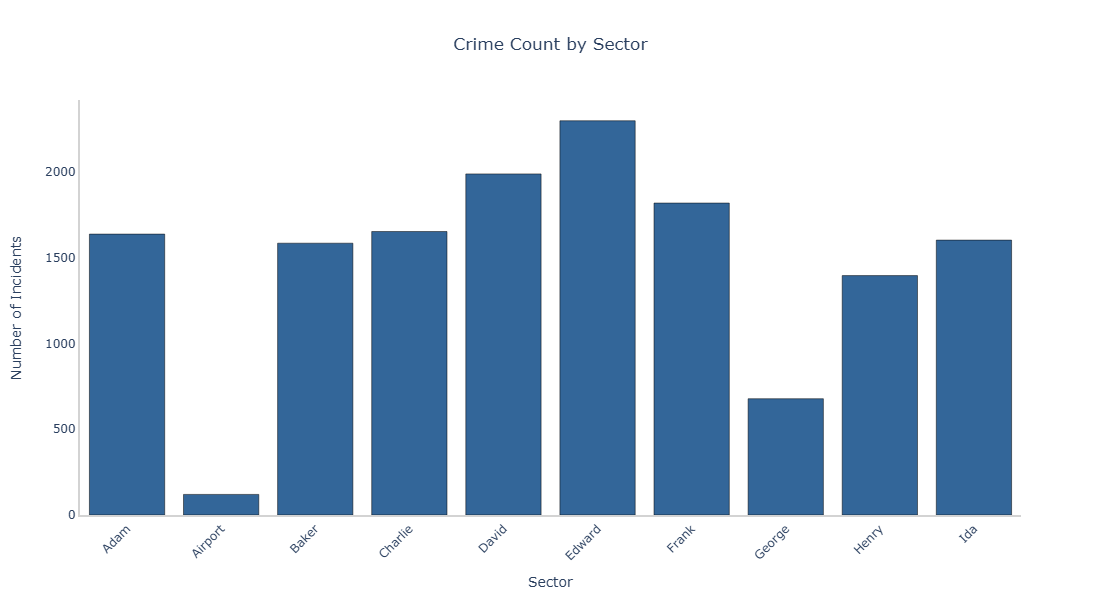

In [270]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=crime_by_sector.index, 
    y=crime_by_sector.values,  
    marker_color='#336699',  
    marker_line_color='black',  
    hovertemplate="Number of Incidents: %{y}<extra></extra>"
))

fig.update_layout(
    title="Crime Count by Sector",
    title_x=0.5,
    xaxis_title="Sector",
    yaxis_title="Number of Incidents",
    xaxis_tickangle=-45,  
    plot_bgcolor="white", 
    height=600, 
    width=800,
    xaxis=dict(
        showgrid=False,  
        zeroline=False,  
        showline=True,  
        linewidth=2,  
        linecolor='lightgrey'  
    ),
    yaxis=dict(
        showgrid=False,  
        zeroline=True,  
        showline=True, 
        linewidth=2,
        linecolor='lightgrey' 
    )
)

fig.show()

In [96]:
# count of priority levels by sector
priority_by_sector = merged_df_clean.groupby(['Sector', 'Priority Level'])['Incident Number'].count().unstack().fillna(0).reset_index()

In [98]:
priority_by_sector

Priority Level,Sector,0,1,2,3
0,Adam,249.0,304.0,745.0,340.0
1,Airport,0.0,38.0,71.0,11.0
2,Baker,184.0,285.0,759.0,357.0
3,Charlie,210.0,341.0,809.0,293.0
4,David,202.0,374.0,991.0,422.0
5,Edward,278.0,517.0,1076.0,428.0
6,Frank,245.0,360.0,852.0,362.0
7,George,33.0,147.0,368.0,130.0
8,Henry,209.0,288.0,633.0,266.0
9,Ida,204.0,324.0,782.0,293.0


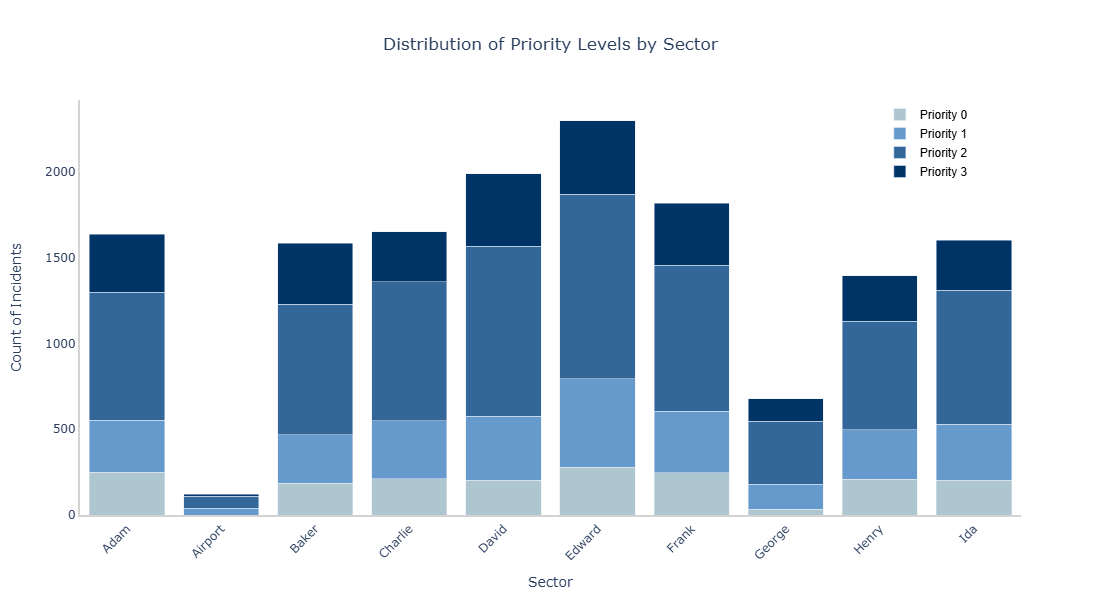

In [192]:
custom_blue_palette = ["#aec6cf", "#6699cc", "#336699", "#003366"]


# priority level column names to strings
priority_by_sector = priority_by_sector.rename(columns=lambda x: str(x))

# get unique priority levels
priority_levels = sorted(priority_by_sector.columns[1:], key=int) 

# sort
sectors = sorted(priority_by_sector["Sector"].unique())

fig = go.Figure()

# make a bar for each priority level
for i, priority in enumerate(priority_levels):
    fig.add_trace(go.Bar(
        x=sectors,
        y=[priority_by_sector[priority_by_sector["Sector"] == sector][priority].sum() for sector in sectors],
        name=f"Priority {priority}",
        marker_color=custom_blue_palette[i % len(custom_blue_palette)],
        hovertemplate="Number of Incidents: %{y}<extra></extra>"
    ))

fig.update_layout(
    title="Distribution of Priority Levels by Sector",
    title_x=0.5,
    xaxis_title="Sector",
    yaxis_title="Count of Incidents",
    xaxis_tickangle=-45, 
    barmode="stack", 
    plot_bgcolor="white",
    height=600,
    width=800,
    xaxis=dict(
        showgrid=False, 
        zeroline=False, 
        showline=True, 
        linewidth=2, 
        linecolor='lightgrey'
    ),
    yaxis=dict(
        showgrid=False,  
        zeroline=True,  
        showline=True, 
        linewidth=2,
        linecolor='lightgrey' 
    ),
    legend=dict(
        x=.85, 
        y=1, 
        traceorder='normal',
        font=dict(
            family='Arial, sans-serif',
            size=12,
            color='black'
        ),
        bgcolor='rgba(255, 255, 255, 1)'
    )
)

fig.show()

In [104]:
# average response time by priority level in each sector
avg_response_time = merged_df_clean.groupby(['Sector', 'Priority Level'])['Response Time'].mean().reset_index()

avg_response_time

,Sector,Priority Level,Response Time
0,Adam,0,438.622490
1,Adam,1,548.555921
2,Adam,2,1074.051007
3,Adam,3,3709.529412
4,Airport,1,300.052632
5,Airport,2,308.985915
6,Airport,3,774.363636
7,Baker,0,437.896739
8,Baker,1,557.631579
9,Baker,2,982.280632


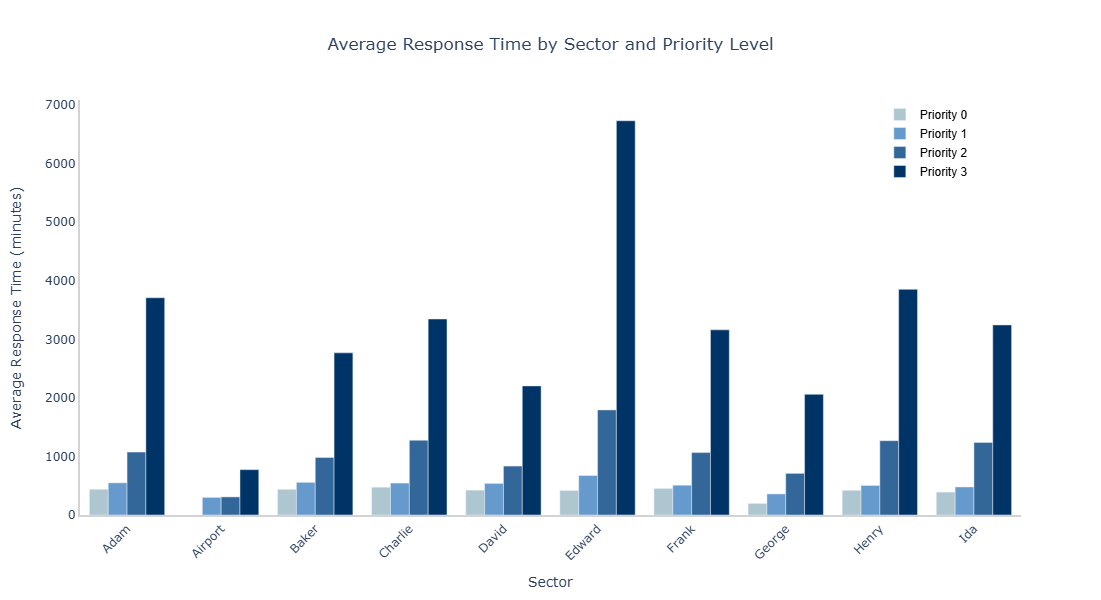

In [238]:
custom_blue_palette = ["#aec6cf", "#6699cc", "#336699", "#003366"]  

# priority level to string
avg_response_time["Priority Level"] = avg_response_time["Priority Level"].astype(str)

# Get unique priority levels
priority_levels = sorted(avg_response_time["Priority Level"].unique()) 

sectors = sorted(avg_response_time["Sector"].unique())

fig = go.Figure()

for i, priority in enumerate(priority_levels):
    subset = avg_response_time[avg_response_time["Priority Level"] == priority]
    
    fig.add_trace(go.Bar(
        x=[sector for sector in sectors],  # x-axis sorted by sector names
        y=[round(subset[subset["Sector"] == sector]["Response Time"].mean(), 2) for sector in sectors],  # y-values
        name=f"Priority {priority}",
        marker_color=custom_blue_palette[i % len(custom_blue_palette)],
        hovertemplate="Average Response Time: %{y:.0f}<extra></extra>"
    ))

fig.update_layout(
    title="Average Response Time by Sector and Priority Level",
    title_x=0.5,
    xaxis_title="Sector",
    yaxis_title="Average Response Time (minutes)",
    xaxis_tickangle=-45,  
    barmode="group", 
    plot_bgcolor="white",
    height=600,
    width=800,
    xaxis=dict(
        showgrid=False,  
        zeroline=False,  
        showline=True,  
        linewidth=2,  
        linecolor='lightgrey'  
    ),
    yaxis=dict(
        showgrid=False,  
        zeroline=True,  
        showline=True, 
        linewidth=2,
        linecolor='lightgrey' 
    ),
    legend=dict(
        x=.85, 
        y=1, 
        traceorder='normal',
        font=dict(
            family='Arial, sans-serif',
            size=12,
            color='black'
        ),
        bgcolor='rgba(255, 255, 255, 1)'
))

fig.show()

In [106]:
# filter rows when response time is above 20,000
high_wait_per_sector = merged_df_clean[merged_df_clean['Response Time'] > 20000]

high_wait_count_per_sector = high_wait_per_sector.groupby('Sector').size()

high_wait_count_per_sector

Sector
Adam        7
Baker       1
Charlie     2
David       1
Edward     38
Frank       2
George      1
Henry       6
Ida         5
dtype: int64

Edward has a larger number of incidents when response time is >20000 seconds compared to the other sectors. This contributes to Edward having the highest average response time.

In [108]:
response_time_stats = merged_df_clean.groupby('Sector')['Response Time'].agg(
    ['mean', 'median', 'std', 'min', 'max', 'count']
)
response_time_stats

,mean,median,std,min,max,count
Sector,,,,,,
Adam,1426.975580,610.5,2602.180187,21.0,37331.0,1638
Airport,348.816667,240.0,374.887479,42.0,3315.0,120
Baker,1245.080757,572.0,2146.927873,52.0,23297.0,1585
Charlie,1390.431942,630.0,2351.008342,34.0,28937.0,1653
David,1028.617898,571.0,1580.601944,6.0,23194.0,1989
Edward,2295.286646,749.0,4704.788163,7.0,60689.0,2299
Frank,1289.965366,587.0,2242.236927,7.0,23872.0,1819
George,868.389381,389.5,1564.728145,32.0,20786.0,678
Henry,1476.767908,604.0,2916.393306,16.0,47192.0,1396


In [109]:
# Kruskal-Wallis test for response times across different sectors
sectors = merged_df_clean['Sector'].dropna().unique()

stat, p_value = stats.kruskal(
    *[merged_df_clean[merged_df_clean['Sector'] == sector]['Response Time'].dropna() for sector in sectors]
)

print(f"Kruskal-Wallis p-value: {p_value}")

Kruskal-Wallis p-value: 1.5892233294861043e-82


In [110]:
# Dunn's test
dunn_results = sp.posthoc_dunn(merged_df_clean, val_col='Response Time', group_col='Sector')

print(dunn_results)

                 Adam       Airport         Baker       Charlie         David  \
Adam     1.000000e+00  4.858165e-29  1.011209e-01  9.872688e-01  9.128417e-04   
Airport  4.858165e-29  1.000000e+00  4.488067e-26  4.992431e-29  7.097834e-24   
Baker    1.011209e-01  4.488067e-26  1.000000e+00  1.036757e-01  1.162920e-01   
Charlie  9.872688e-01  4.992431e-29  1.036757e-01  1.000000e+00  9.407764e-04   
David    9.128417e-04  7.097834e-24  1.162920e-01  9.407764e-04  1.000000e+00   
Edward   2.009350e-10  1.738496e-41  7.104378e-16  1.607625e-10  5.197827e-25   
Frank    1.725362e-01  7.387383e-27  7.422799e-01  1.766965e-01  4.790183e-02   
George   8.646147e-25  2.851443e-09  2.922701e-19  8.514047e-25  7.110201e-16   
Henry    2.883812e-01  8.906900e-27  6.029737e-01  2.943630e-01  3.927506e-02   
Ida      5.540310e-03  3.436446e-24  2.625235e-01  5.706411e-03  6.943164e-01   

               Edward         Frank        George         Henry           Ida  
Adam     2.009350e-10  1.725

Adam and Airport: p-value = 5.86e-29 (significant difference)  
Adam and David: p-value = 8.63e-04 (significant difference)   
Adam and Edward: p-value = 7.48e-11 (significant difference)    
Airport and David: p-value = 8.23e-24 (significant difference)   
Airport and Edward: p-value = 1.36e-41 (significant difference)     
Baker and Airport: p-value = 5.27e-26 (significant difference)   
Charlie and David: p-value = 3.40e-04 (significant difference)   
Charlie and Edward: p-value = 2.81e-10 (significant difference)  
David and Edward: p-value = 7.97e-26 (significant difference)  
Frank and George: p-value = 5.96e-21 (significant difference)  
George and Edward: p-value = 1.72e-54 (significant difference)  
George and Henry: p-value = 1.60e-20 (significant difference)  
Ida and Adam: p-value = 9.45e-03 (significant difference)  
Ida and Airport: p-value = 1.87e-24 (significant difference)  
Ida and Edward: p-value = 1.65e-20 (significant difference)  

In [112]:
avg_response_sector = merged_df_clean.groupby("Sector")["Response Time"].mean().reset_index()
pop_sector = {
    "Baker": 123999,
    "Airport": 0,
    "George": 11835,
    "Ida": 61607,
    "Adam": 137527,
    "Edward": 100894,
    "Charlie": 60120,
    "Henry": 66059,
    "David": 139085,
    "Frank": 132014
}
pop_df = pd.DataFrame(list(pop_sector.items()), columns=["Sector", "Population"])

pop_and_sector_df = avg_response_sector.merge(pop_df, on="Sector")

pop_and_sector_df = pop_and_sector_df[pop_and_sector_df["Population"] > 0]

corr, p_value = spearmanr(pop_and_sector_df["Response Time"], pop_and_sector_df["Population"])

print(f"Spearman's correlation: {corr:.4f}")
print(f"P-value: {p_value:.4f}")

Spearman's correlation: 0.0000
P-value: 1.0000


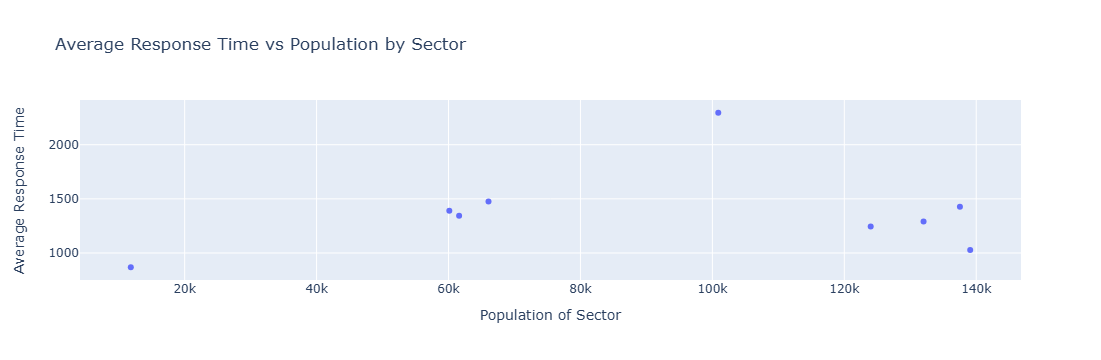

In [113]:
fig = px.scatter(pop_and_sector_df, x="Population", y="Response Time",
                 title="Average Response Time vs Population by Sector",
                 labels={"Population": "Population of Sector", "Response Time": "Average Response Time"},
                 hover_data=["Sector"])

fig.show()

In [114]:
merged_copy = merged_df_clean.copy()

In [115]:
merged_copy['Year'] = merged_copy['Occurred Date Time'].dt.year

# response time threshold 10 minutes 44 seconds = 644 seconds
response_time_threshold = 644

# new column indicating whether the response time is below or equal to the threshold
merged_copy['Fast Response'] = merged_copy['Response Time'] <= response_time_threshold

# group by year and calculate the percentage of fast responses
fast_response_percentage_by_year = merged_copy.groupby('Year')['Fast Response'].mean() * 100

print(fast_response_percentage_by_year)

Year
2004.0    42.439024
2005.0    41.860465
2006.0    48.072289
2007.0    48.959608
2008.0    66.773676
2009.0    61.986301
2010.0    65.684575
2011.0    61.370262
2012.0    60.809102
2013.0    62.649007
2014.0    60.052219
2015.0    46.082337
2016.0    48.439620
2017.0    52.582781
2018.0    52.286585
2019.0    55.167394
2020.0    54.961832
2021.0    52.317881
2022.0    51.154529
2023.0    52.305246
2024.0    50.000000
Name: Fast Response, dtype: float64


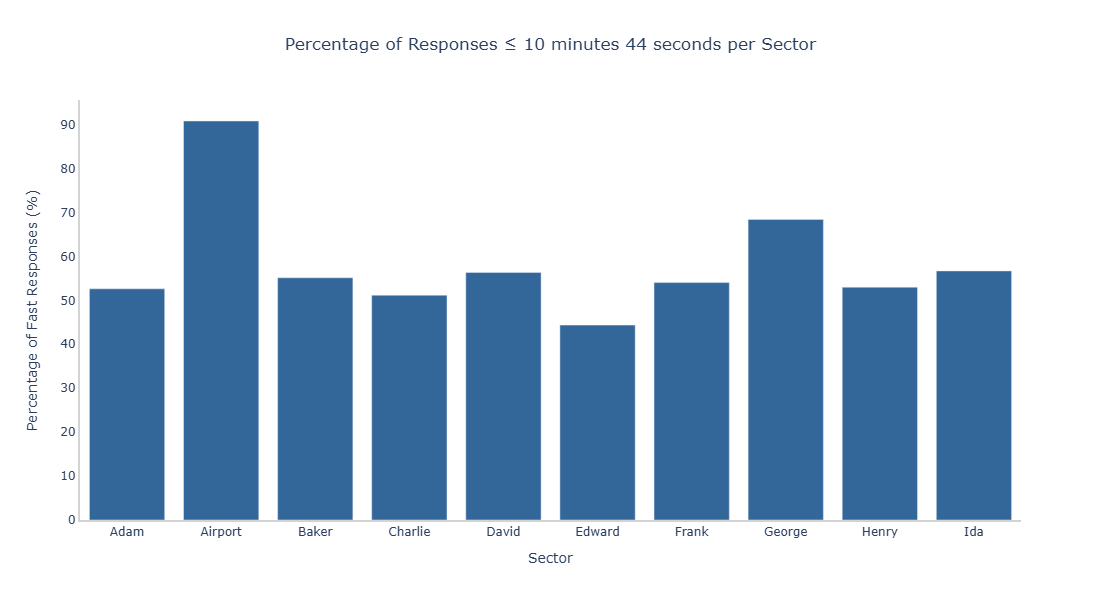

In [206]:
# group by sector and calculate the percentage of fast responses
fast_response_percentage_by_sector = merged_copy.groupby('Sector')['Fast Response'].mean() * 100

fig = go.Figure()

fig.add_trace(go.Bar(
    x=fast_response_percentage_by_sector.index,
    y=fast_response_percentage_by_sector,
    marker_color='#336699',
    hovertemplate="%{y:.1f}%<extra></extra>"
))

fig.update_layout(
    title="Percentage of Responses ≤ 10 minutes 44 seconds per Sector",
    title_x=0.5,
    xaxis_title="Sector",
    yaxis_title="Percentage of Fast Responses (%)",
    plot_bgcolor="white",
    height=600,
    width=800,
    xaxis=dict(
        showgrid=False,  
        zeroline=False,  
        showline=True,  
        linewidth=2,  
        linecolor='lightgrey'  
    ),
    yaxis=dict(
        showgrid=False,  
        zeroline=True,  
        showline=True, 
        linewidth=2,
        linecolor='lightgrey' 
    )
)

fig.show()

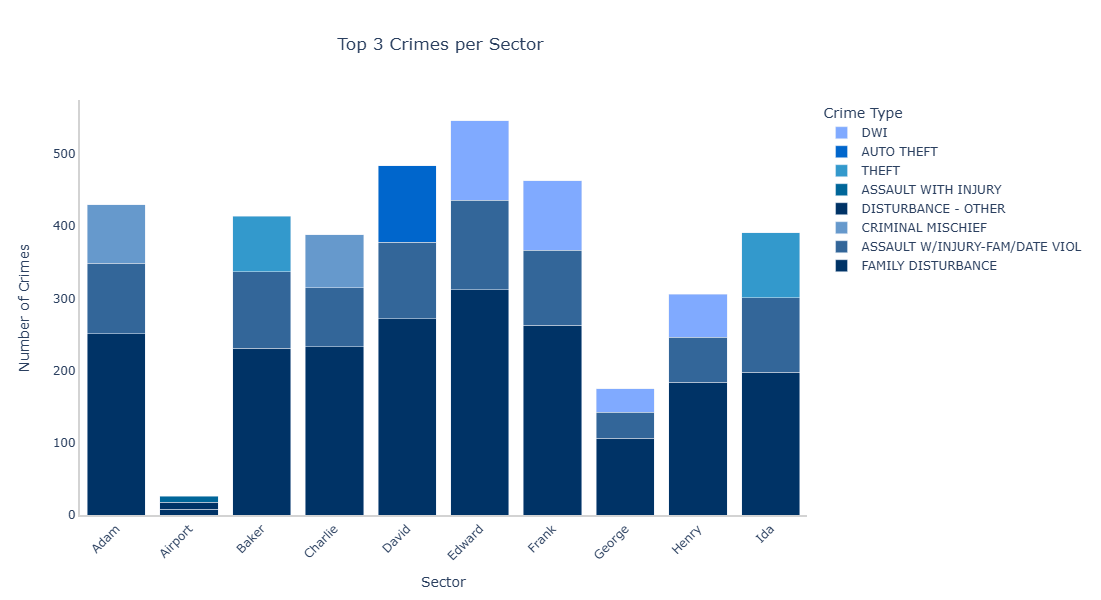

In [117]:
crime_counts_sector = (
    merged_df_clean.groupby(["Sector", "Highest Offense Description"])["Incident Number"]
    .count()
    .reset_index()
)

# top 3 crimes per sector
top_3_per_sector = crime_counts_sector.groupby("Sector").apply(lambda x: x.nlargest(3, "Incident Number"), include_groups=False).reset_index(drop=False)

custom_blue_palette = ["#003366", "#336699", "#6699cc",
    "#003366", "#006699", "#3399cc", 
    "#0066cc", "#80aaff"] 

# create a bar for each crime type
fig = go.Figure()

for i, crime_type in enumerate(top_3_per_sector["Highest Offense Description"].unique()):
    subset = top_3_per_sector[top_3_per_sector["Highest Offense Description"] == crime_type]
    
    fig.add_trace(go.Bar(
        x=subset["Sector"],
        y=subset["Incident Number"],
        name=crime_type,
        marker_color=custom_blue_palette[i % len(custom_blue_palette)],  
        hovertemplate="<b>Crime Type:</b> %{customdata[0]}<br>"
                      "<b>Number of Crimes:</b> %{y}<extra></extra>",
        customdata=subset[["Highest Offense Description"]].values 
    ))

fig.update_layout(
    title="Top 3 Crimes per Sector",
    title_x=0.4,
    xaxis_title="Sector",
    yaxis_title="Number of Crimes",
    barmode="stack", 
    xaxis_tickangle=-45,  
    plot_bgcolor="white",
    height=600,
    width=1000,
    legend_title="Crime Type",
    showlegend=True,
    xaxis=dict(
        showgrid=False,  
        zeroline=False,  
        showline=True,  
        linewidth=2,  
        linecolor='lightgrey'  
    ),
    yaxis=dict(
        showgrid=False,  
        zeroline=True,  
        showline=True, 
        linewidth=2,
        linecolor='lightgrey' 
    )
)

fig.show()

### Time series analysis

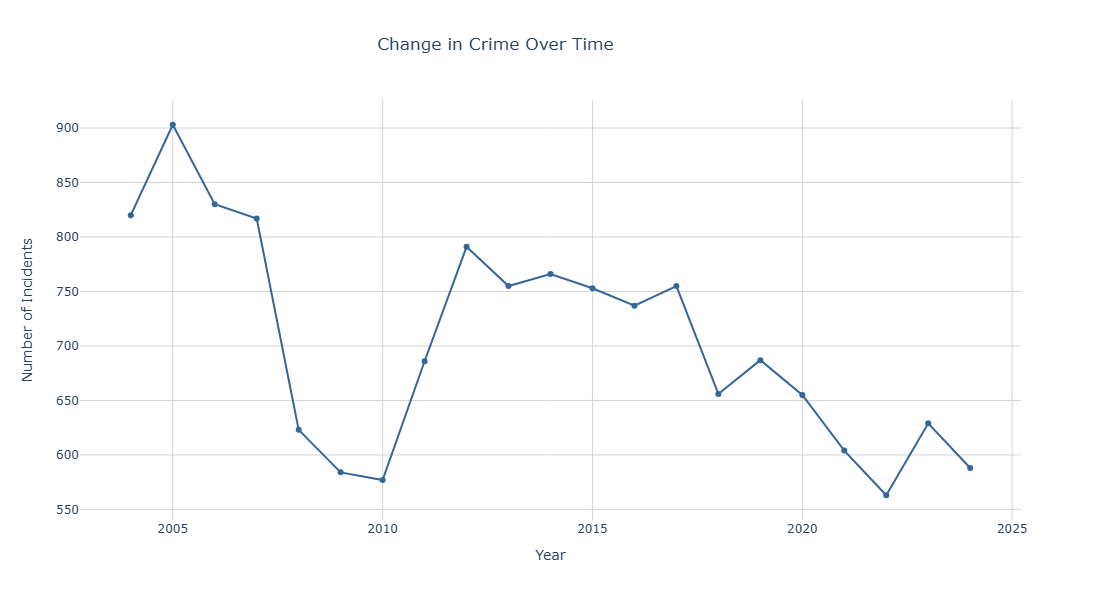

In [220]:
# datetime format
merged_df_clean['Occurred Date Time'] = pd.to_datetime(merged_df_clean['Occurred Date Time'], errors='coerce')

merged_df_clean['Year'] = merged_df_clean['Occurred Date Time'].dt.year

crime_by_year = merged_df_clean.groupby('Year')['Incident Number'].count().reset_index()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=crime_by_year['Year'],
    y=crime_by_year['Incident Number'],
    mode='lines+markers',
    name='Crime Count',
    line=dict(color='#336699'),
    hovertemplate="Number of Incidents: %{y}<br> Year: %{x}<br><extra></extra>"
))

fig.update_layout(
    title='Change in Crime Over Time',
    title_x=0.45, 
    xaxis_title='Year',
    yaxis_title='Number of Incidents',
    template='plotly',
    showlegend=False,
    height=600,
    width=800,
    plot_bgcolor='white', 
    xaxis=dict(
        showgrid=True,  
        gridcolor='lightgrey', 
        gridwidth=1  
    ),
    yaxis=dict(
        showgrid=True, 
        gridcolor='lightgrey', 
        gridwidth=1 
    )
)

fig.show()

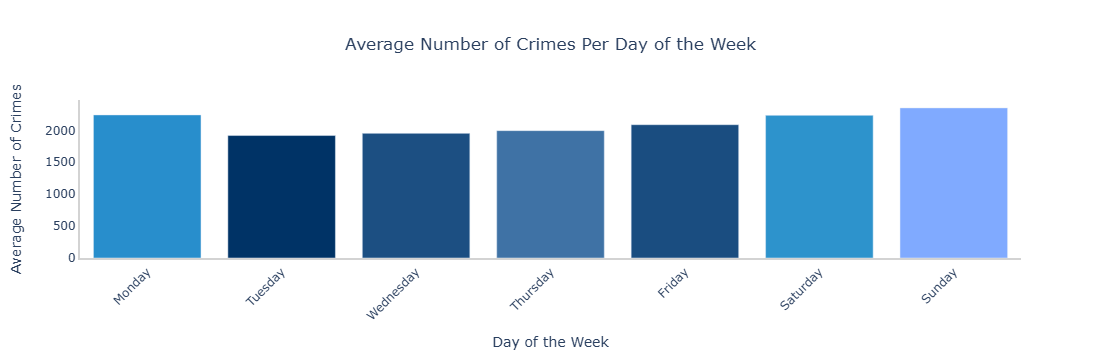

In [198]:
merged_df_clean['Day of Week'] = merged_df_clean['Occurred Date Time'].dt.dayofweek

avg_crimes_per_day = merged_df_clean.groupby('Day of Week')['Incident Number'].nunique()

avg_incidents_per_day = avg_crimes_per_day.mean()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_crimes_per_day.index = days

custom_blue_palette = ["#003366", "#336699", "#6699cc", 
                       "#003366", "#006699", "#3399cc",  
                       "#0066cc", "#80aaff"]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=avg_crimes_per_day.index,
    y=avg_crimes_per_day.values,
    marker=dict(color=avg_crimes_per_day.values, colorscale=custom_blue_palette),
    hovertemplate="Number of Incidents: %{y}<extra></extra>"
))

fig.update_layout(
    title='Average Number of Crimes Per Day of the Week',
    title_x=0.5,
    xaxis_title='Day of the Week',
    yaxis_title='Average Number of Crimes',
    xaxis_tickangle=-45,
    template='plotly',
    showlegend=False,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False, showline=True, linewidth=2, linecolor='lightgrey'),
    yaxis=dict(showgrid=False, zeroline=True, showline=True, linewidth=2, linecolor='lightgrey'),
)

fig.show()

In [121]:
print(avg_crimes_per_day)

Monday       2241
Tuesday      1918
Wednesday    1952
Thursday     1995
Friday       2088
Saturday     2234
Sunday       2351
Name: Incident Number, dtype: int64


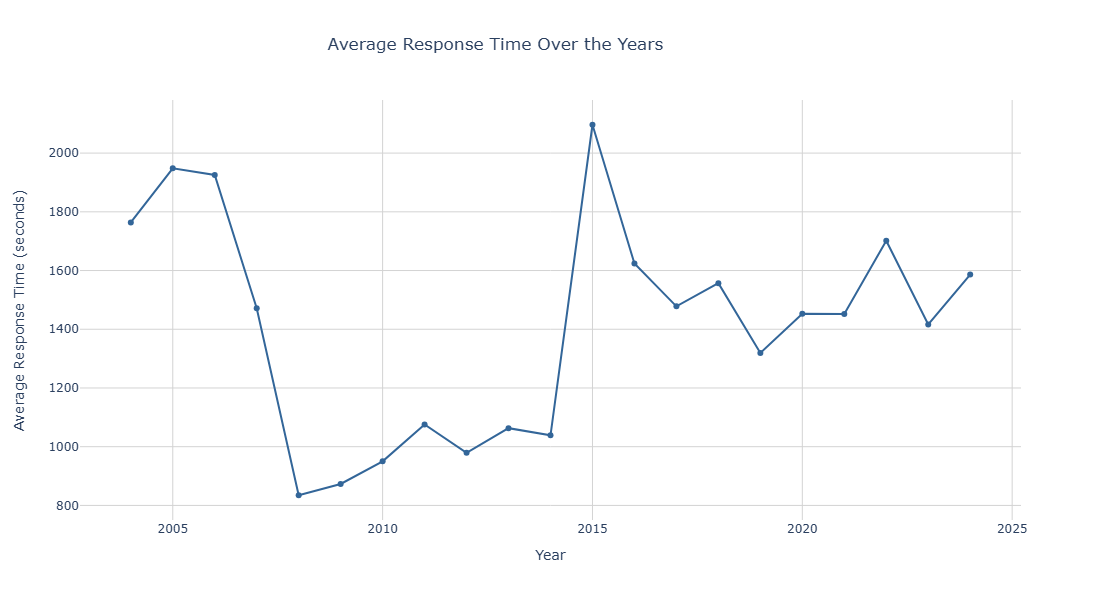

In [228]:
merged_df_clean['Year'] = merged_df_clean['Occurred Date Time'].dt.year

avg_response_time_by_year = merged_df_clean.groupby('Year')['Response Time'].mean().reset_index()

fig = go.Figure()

fig.add_trace(go.Scatter(x=avg_response_time_by_year['Year'],
                         y=avg_response_time_by_year['Response Time'],
                         mode='lines+markers',
                         name='Average Response Time',
                         line=dict(color='#336699'),
                         hovertemplate="Response Time (s): %{y:.0f}<br> Year: %{x}<br><extra></extra>"
                        ))

fig.update_layout(
    title='Average Response Time Over the Years',
    title_x=0.45,
    xaxis_title='Year',
    yaxis_title='Average Response Time (seconds)',
    template='plotly', 
    showlegend=False,
    height=600,
    width=800,
    plot_bgcolor='white',
    xaxis=dict(
        showgrid=True,  
        gridcolor='lightgrey', 
        gridwidth=1 
    ),
    yaxis=dict(
        showgrid=True, 
        gridcolor='lightgrey', 
        gridwidth=1 
    )
)

fig.show()

In [272]:
avg_response_time_by_year["Response Time"].describe()

count      21.000000
mean     1409.898236
std       370.223316
min       834.656501
25%      1063.170861
50%      1452.641221
75%      1623.957938
max      2096.547145
Name: Response Time, dtype: float64

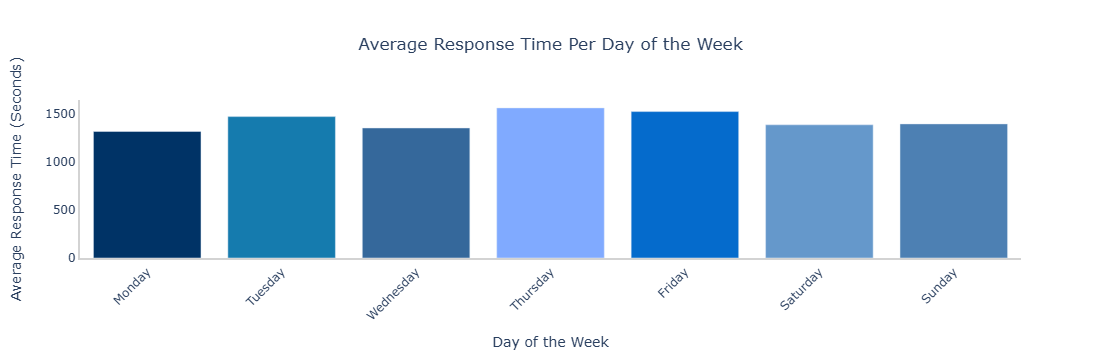

In [254]:
merged_df_clean['Day of Week'] = merged_df_clean['Occurred Date Time'].dt.dayofweek

avg_response_time_per_day = merged_df_clean.groupby('Day of Week')['Response Time'].mean()

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_response_time_per_day.index = day_names

custom_blue_palette = ["#003366", "#336699", "#6699cc", 
    "#003366", "#006699", "#3399cc",  
    "#0066cc", "#80aaff"] 

fig = go.Figure()

fig.add_trace(go.Bar(
    x=avg_response_time_per_day.index,
    y=avg_response_time_per_day.round(2).values,
    marker=dict(color=avg_response_time_per_day.values, colorscale=custom_blue_palette),
    hovertemplate="Response Time: %{y:.0f}<extra></extra>"
))

fig.update_layout(
    title='Average Response Time Per Day of the Week',
    title_x=0.5,
    xaxis_title='Day of the Week',
    yaxis_title='Average Response Time (Seconds)',
    xaxis_tickangle=-45,  
    template='plotly',  
    showlegend=False,  
    plot_bgcolor='white', 
    paper_bgcolor='white',
    xaxis=dict(
        showgrid=False,
        zeroline=False, 
        showline=True, 
        linewidth=2,
        linecolor='lightgrey'
    ),
    yaxis=dict(
        showgrid=False, 
        zeroline=True,  
        showline=True, 
        linewidth=2, 
        linecolor='lightgrey' 
    ),
)

fig.show()

In [252]:
avg_response_time_per_day.describe()

count       7.000000
mean     1432.181636
std        91.187542
min      1319.055779
25%      1371.875770
50%      1397.910251
75%      1499.963659
max      1564.626566
Name: Response Time, dtype: float64

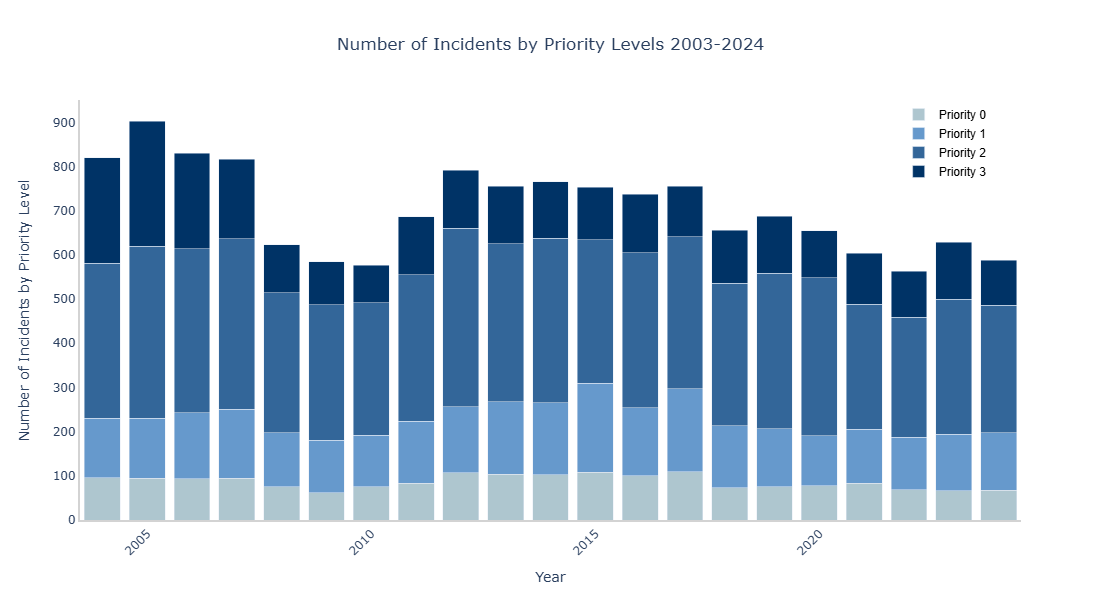

In [258]:
priority_count_per_year = merged_df_clean.groupby(['Year', 'Priority Level']).size().unstack(fill_value=0)

blue_palette = ['#aec6cf', '#6699cc', '#336699', '#003366']

fig = go.Figure()

for i, priority_level in enumerate(priority_count_per_year.columns):
    fig.add_trace(go.Bar(
        x=priority_count_per_year.index,
        y=priority_count_per_year[priority_level],
        name=f"Priority {priority_level}",
        marker_color=blue_palette[i % len(blue_palette)],
        hovertemplate="Number of Incidents: %{y}<extra></extra>"
    ))

fig.update_layout(
    title='Number of Incidents by Priority Levels 2003-2024',
    title_x=0.5,
    xaxis_title='Year',
    yaxis_title='Number of Incidents by Priority Level',
    barmode='stack',
    xaxis_tickangle=-45,
    height=600,
    width=1000,
    plot_bgcolor='white',
    template='plotly',
    showlegend=True,
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=True,
        linewidth=2,
        linecolor='lightgrey'
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=True,
        showline=True,
        linewidth=2,
        linecolor='lightgrey'
    ),
    legend=dict(
        x=.87,
        y=1,
        traceorder='normal',
        font=dict(
            family='Arial, sans-serif',
            size=12,
            color='black'
        ),
        bgcolor='rgba(255, 255, 255, 0)'
    )
)

fig.show()

In [260]:
priority_count_per_year.describe()

Priority Level,0,1,2,3
count,21.000000,21.000000,21.000000,21.000000
mean,86.380952,141.809524,337.428571,138.142857
std,15.428792,23.316559,36.893863,50.011284
min,62.000000,113.000000,272.000000,85.000000
25%,75.000000,123.000000,306.000000,109.000000
50%,83.000000,135.000000,344.000000,128.000000
75%,100.000000,154.000000,357.000000,131.000000
max,109.000000,201.000000,404.000000,283.000000


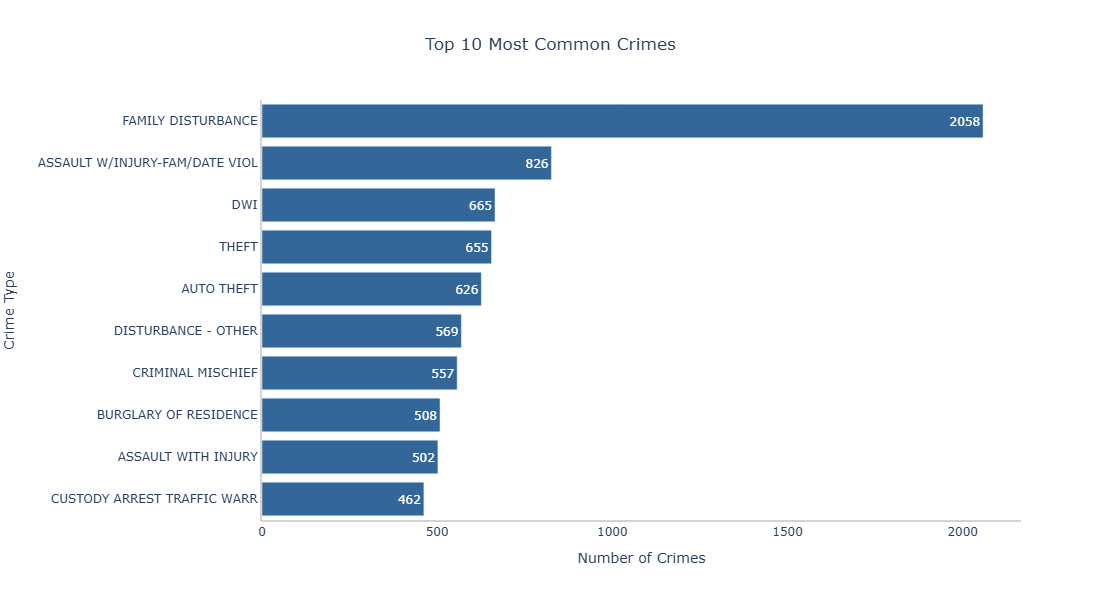

In [125]:
crime_counts = (
    merged_df_clean.groupby("Highest Offense Description")["Incident Number"]
    .count()
    .reset_index()
    .sort_values(by="Incident Number", ascending=False)  
    .head(10) 
)

blue_palette = ['#003366', '#336699', '#6699cc', '#aec6cf', '#cce0ff', '#b3d9ff', '#80b3ff', '#4d99ff', '#1a80ff', '#0073e6']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=crime_counts["Incident Number"], 
    y=crime_counts["Highest Offense Description"], 
    orientation='h',  
    marker_color="#336699",
    text=crime_counts["Incident Number"],  
    textposition='inside',
    hoverinfo="none"
))

fig.update_layout(
    title='Top 10 Most Common Crimes',
    title_x=0.5,
    xaxis_title='Number of Crimes',
    yaxis_title='Crime Type',
    plot_bgcolor='white',  
    template='plotly',  
    height=600,
    width=1000,
    showlegend=False, 
    yaxis=dict(
        categoryorder='total ascending', 
        showgrid=False, 
        zeroline=True,  
        showline=True, 
        linewidth=2,  
        linecolor='lightgrey'  
    ),
    xaxis=dict(
        showgrid=False,  
        zeroline=False,  
        showline=True,  
        linewidth=2,  
        linecolor='lightgrey'  
    )
)

fig.show()

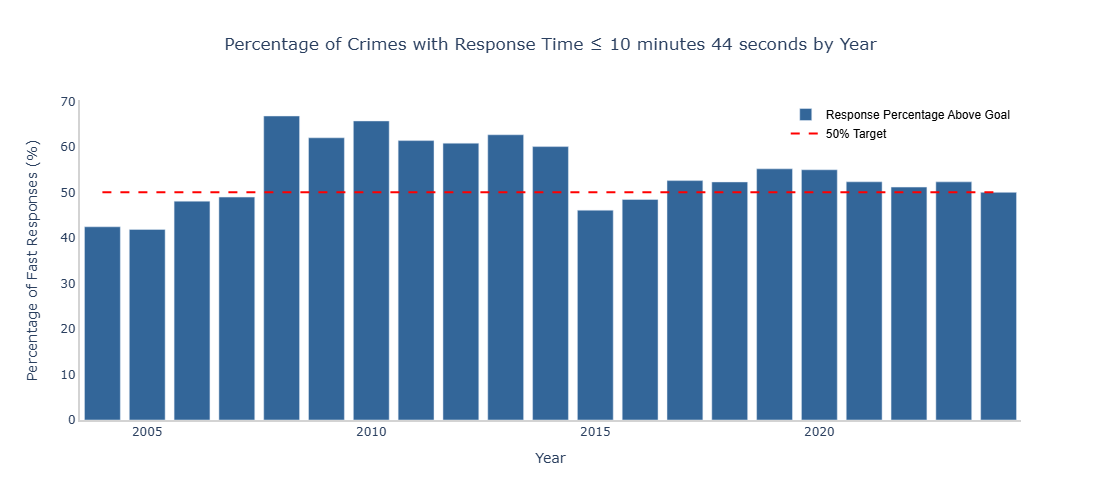

In [208]:
target_percentage = 50

fig = go.Figure()

fig.add_trace(go.Bar(
    x=fast_response_percentage_by_year.index,
    y=fast_response_percentage_by_year,
    marker_color='#336699',
    name="Response Percentage Above Goal",
    hovertemplate="%{y:.1f}%<extra></extra>" 
))


# add reference line at the 50% target
fig.add_trace(go.Scatter(
    x=fast_response_percentage_by_year.index,
    y=[target_percentage] * len(fast_response_percentage_by_year),
    mode='lines', 
    line=dict(dash='dash', color='red'),
    name="50% Target",
    showlegend=True,
    hoverinfo="skip"
))

fig.update_layout(
    title="Percentage of Crimes with Response Time ≤ 10 minutes 44 seconds by Year",
    title_x=0.5,
    xaxis_title="Year",
    yaxis_title="Percentage of Fast Responses (%)",
    xaxis=dict(
        showgrid=False, 
        zeroline=False, 
        showline=True,
        linewidth=2, 
        linecolor='lightgrey' 
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=True,  
        showline=True, 
        linewidth=2,  
        linecolor='lightgrey' 
    ),
    plot_bgcolor='white', 
    height=500,
    width=1100,
    legend=dict(
        x=.75,  
        y=1,  
        traceorder='normal',
        font=dict(
            family='Arial, sans-serif',
            size=12,
            color='black'
        ),
        bgcolor='rgba(255, 255, 255, 0)'  
    )
)


fig.show()

### Modeling

#### K Nearest Neighbors

In [129]:
X = merged_df_clean[['Priority Level', 'Highest Offense Code', 'Census Block Group', 'Response Day of Week', 'Number of Units Arrived']]
y = merged_df_clean['Response Time']

In [130]:
X = X.dropna()
X = pd.get_dummies(X, drop_first=True)
y = y[X.index]

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
# KNN with 5 neighbors
knn = KNeighborsRegressor(n_neighbors=5)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 1451.7088194444445


#### Random Forest

In [134]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [135]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 1296.4532956706742
Root Mean Squared Error: 2933.692422930676
R-squared: -0.08507710699404414


#### Gradient Boosting

In [137]:
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_gb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2 = r2_score(y_test, y_pred_gb)

print("Gradient Boosting MAE:", mae)
print("Gradient Boosting RMSE:", rmse)
print("Gradient Boosting R²:", r2)

Gradient Boosting MAE: 1223.0624007811543
Gradient Boosting RMSE: 2801.445273365412
Gradient Boosting R²: 0.010545727262362803


#### XGBoost

In [139]:
xgb = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))

XGBoost MAE: 1254.6797953845726
XGBoost RMSE: 2883.304987105955
XGBoost R²: -0.04812386288333137


#### Decision Tree

In [141]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 12889602.624263845
Root Mean Squared Error: 3590.209273045771


All models performed poorly, Gradient Boosting had the lowest MAE and RMSE